## Load and Visualize Data

In [9]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

## Dataset class and Transformations

In [11]:
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms, utils

class FacialKeypointsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])        
        image = mpimg.imread(image_name)
        
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].values
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class Normalize(object):
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image_copy=  image_copy/255.0
        key_pts_copy = (key_pts_copy - 100)/50.0
        return {'image': image_copy, 'keypoints': key_pts_copy}

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))        
        key_pts = key_pts * [new_w / w, new_h / h]
        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h,
                      left: left + new_w]
        key_pts = key_pts - [left, top]
        return {'image': image, 'keypoints': key_pts}

class ToTensor(object):
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        if(len(image.shape) == 2):
            image = image.reshape(image.shape[0], image.shape[1], 1)
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

## Create the transformed dataset

In [13]:
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])
transformed_dataset = FacialKeypointsDataset(csv_file='E:\\Projects\\udacity_cv\\train-test-data\\training_frames_keypoints.csv',
                                      root_dir='E:\\Projects\\udacity_cv\\train-test-data\\training',
                                             transform=data_transform)
print('Number of images: ', len(transformed_dataset))

Number of images:  3462


## Define the Convolutional Neural Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3) 
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)   
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)       

        self.fc1 = nn.Linear(in_features=51200, out_features=4096)        
        self.fc2 = nn.Linear(in_features=4096, out_features=1000)
        self.fc3 = nn.Linear(in_features=1000, out_features=136) 
        
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.3)
        self.dropout4 = nn.Dropout(p=0.4)
        self.dropout5 = nn.Dropout(p=0.5)
        self.dropout6 = nn.Dropout(p=0.6)


        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.bn4 = nn.BatchNorm2d(num_features=128)
        self.bn5 = nn.BatchNorm2d(num_features=256)
        self.bn6 = nn.BatchNorm2d(num_features=256)
        self.bn7 = nn.BatchNorm2d(num_features=512)
        self.bn8 = nn.BatchNorm2d(num_features=512)
        self.bn9 = nn.BatchNorm1d(num_features=4096)
        self.bn10 = nn.BatchNorm1d(num_features=1000)       

    def forward(self, x):    
        x = F.relu(self.conv1(x))
        x= self.bn1(x)
        x = F.relu(self.conv2(x))
        x= self.bn2(x)
        x= self.pool(x)        
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.pool(self.bn6(F.relu(self.conv6(x))))        
        x = self.bn7(F.relu(self.conv7(x)))
        x = self.pool(self.bn8(F.relu(self.conv8(x))))
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.bn9(x)
        x = self.dropout5(x)
        
        x = F.relu(self.fc2(x))
        x = self.bn10(x)
        x = self.dropout5(x)
        
        x = self.fc3(x)
        
        return x
net = Net()
net

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=51200, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (dropout1): Dropout(p=0.1)
  (dropout2): Dropout(p=0.2)
  (dropout3): Dropout(p=0.3)
  (dropout4): Dropout(p=0.4)
  (dropout5): Dropout(p=0.5)
  (dropout6): Dropout(p=0.6)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0

## Data Loader

In [6]:
batch_size = 16
train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [7]:
test_dataset = FacialKeypointsDataset(csv_file='E:\\Projects\\udacity_cv\\train-test-data\\test_frames_keypoints.csv',
                                             root_dir='E:\\Projects\\udacity_cv\\train-test-data\\test',
                                             transform=data_transform)

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [9]:
def net_sample_output():    
    for i, sample in enumerate(test_loader):        
        images = sample['image']
        key_pts = sample['keypoints']
        images = images.type(torch.FloatTensor).to(device)
        output_pts = net(images)        
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)        
        if i == 0:
            return images, output_pts, key_pts

## Visualize the predicted keypoints

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None, axis=None):
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')
        if axis is not None:
            for i in range(len(gt_pts[:, 0])):
                axis.annotate(str(i), (gt_pts[i, 0],gt_pts[i, 1]))

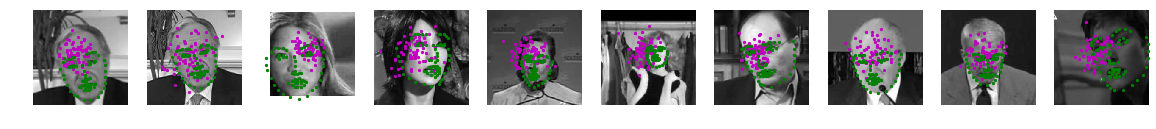

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20,10]
import numpy as np

def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    
    plt.figure(figsize=(20,10))
    for i in range(batch_size):
        ax = plt.subplot(1, batch_size, i+1)
        image = test_images[i].data
        image = image.cpu().numpy()   
        image = np.transpose(image, (1, 2, 0))
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        predicted_key_pts = predicted_key_pts*50.0+100
        
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()    
visualize_output(test_images, test_outputs, gt_pts)

## Training

In [13]:
import torch.optim as optim
lr=0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [14]:
def train_net(n_epochs):
    valid_loss_min = np.Inf    
    history = {'train_loss': [], 'valid_loss': [], 'epoch': []}

    for epoch in range(n_epochs):  
        train_loss = 0.0
        valid_loss = 0.0  
        net.train()
        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']
            key_pts = key_pts.view(key_pts.size(0), -1)
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)
            output_pts = net(images)
            loss = criterion(output_pts, key_pts)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*images.data.size(0)      
        net.eval() 
        
        with torch.no_grad():
            for batch_i, data in enumerate(test_loader):
                images = data['image']
                key_pts = data['keypoints']
                key_pts = key_pts.view(key_pts.size(0), -1)
                key_pts = key_pts.type(torch.FloatTensor).to(device)
                images = images.type(torch.FloatTensor).to(device)
                output_pts = net(images)
                loss = criterion(output_pts, key_pts)          
                valid_loss += loss.item()*images.data.size(0) 
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset) 
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1,train_loss,valid_loss))
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))    
            torch.save(net,f'E:\\Projects\\udacity_cv\\P1\\epoch{epoch + 1}_loss{valid_loss}.pth')
            valid_loss_min = valid_loss
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
    print('Finished Training')
    return history

In [16]:
n_epochs = 15 
history=train_net(n_epochs)

Epoch: 1 	Training Loss: 0.314890
Validation loss decreased (inf --> 0.122625).  Saving model ...


H:\Anaconda3\envs\main\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2 	Training Loss: 0.172457
Validation loss decreased (0.122625 --> 0.111235).  Saving model ...
Epoch: 3 	Training Loss: 0.120376
Validation loss decreased (0.111235 --> 0.094633).  Saving model ...
Epoch: 4 	Training Loss: 0.098483
Validation loss decreased (0.094633 --> 0.069545).  Saving model ...
Epoch: 5 	Training Loss: 0.081972
Epoch: 6 	Training Loss: 0.079680
Validation loss decreased (0.069545 --> 0.056769).  Saving model ...
Epoch: 7 	Training Loss: 0.090706
Epoch: 8 	Training Loss: 0.084803
Epoch: 9 	Training Loss: 0.103940
Validation loss decreased (0.056769 --> 0.046373).  Saving model ...
Epoch: 10 	Training Loss: 0.087255
Epoch: 11 	Training Loss: 0.089165
Epoch: 12 	Training Loss: 0.072716
Epoch: 13 	Training Loss: 0.081536
Epoch: 14 	Training Loss: 0.069549
Epoch: 15 	Training Loss: 0.065642
Finished Training


In [ ]:
#net=torch.load("E:\\Projects\\udacity_cv\\P1\\epoch13_loss0.07255.pth")

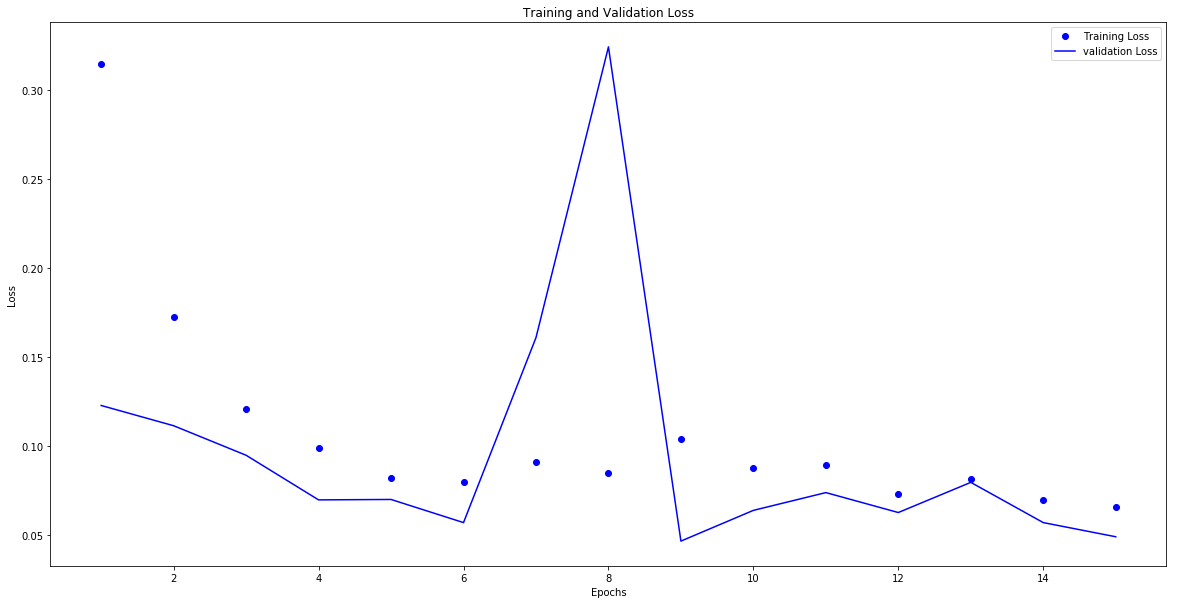

In [18]:
import matplotlib.pyplot as plt

train_loss=history['train_loss']
val_loss=history['valid_loss']
history.keys()

epochs= range(1,len(train_loss)+1)

plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## visualize result

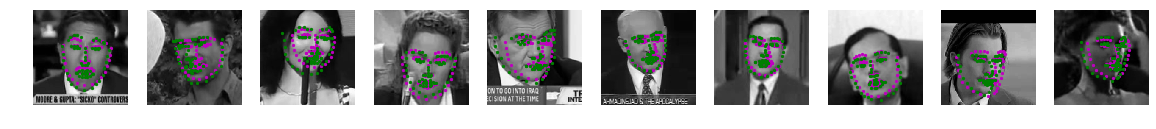

In [20]:
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images, test_outputs, gt_pts)

## Try with other image

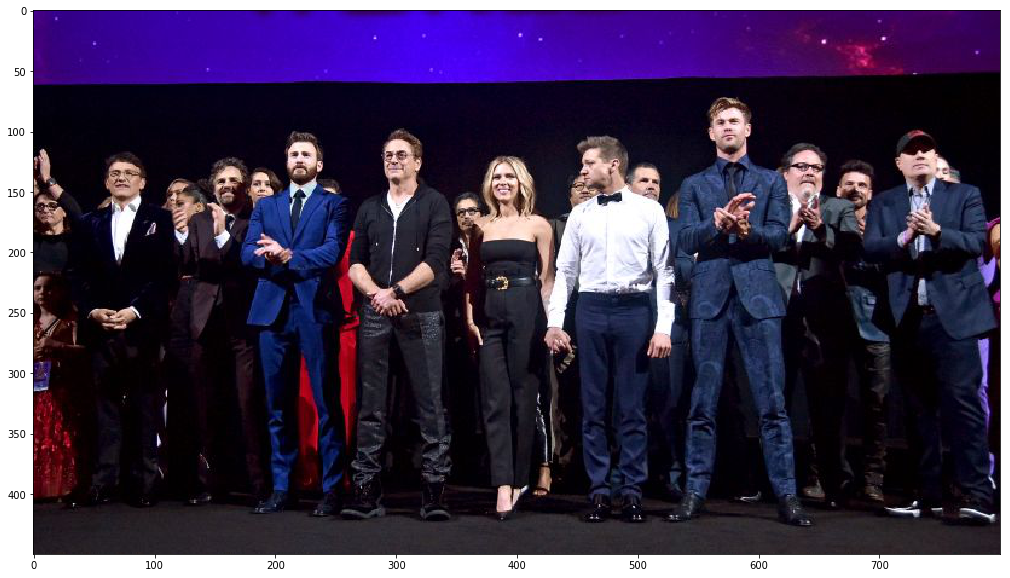

In [10]:
import cv2
image = cv2.imread('endgame-carpet.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

## Detect all faces in an image

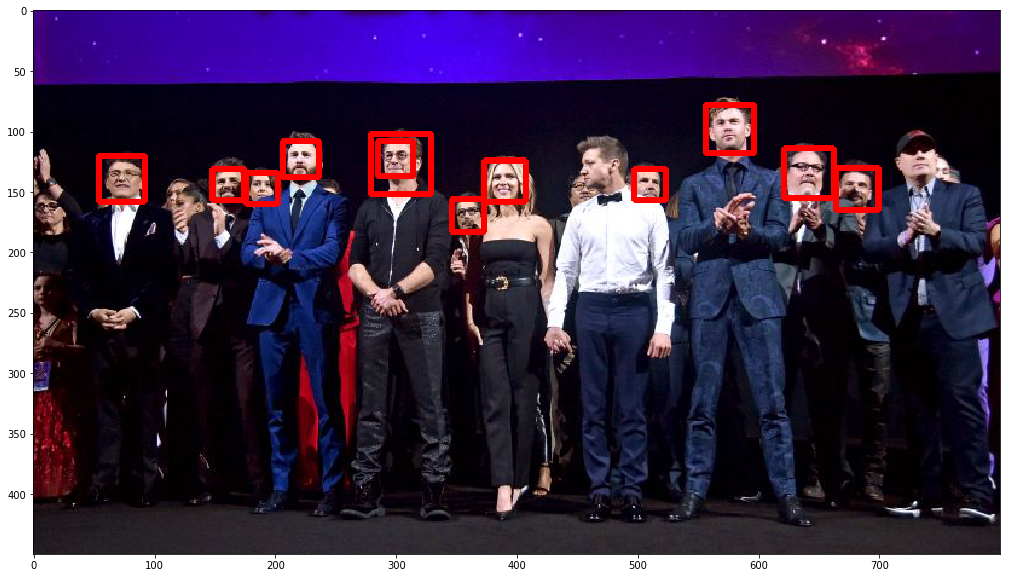

In [11]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(image, scaleFactor=1.2, minNeighbors=2)
image_with_detections = image.copy()
for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

plt.imshow(image_with_detections)

## Keypoint detection

In [5]:
def roi_transform(roi, output_size=224):
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    roi = roi / 255.0    
    roi = cv2.resize(roi, (output_size, output_size))    
    roi_tensor=torch.from_numpy(roi.reshape(1,1,output_size,output_size))  
    roi_tensor = roi_tensor.type(torch.FloatTensor)
    return roi, roi_tensor

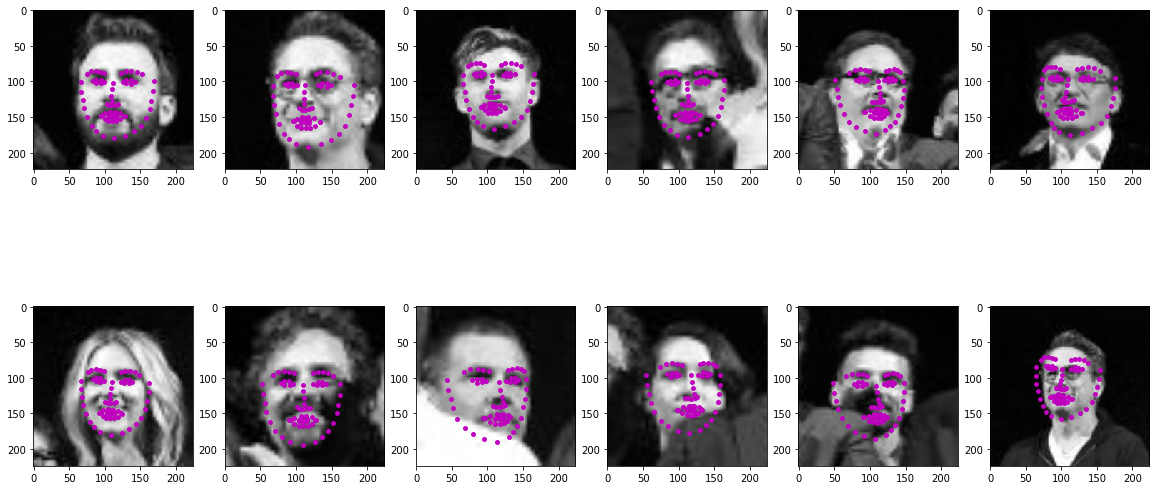

In [6]:
net.eval()
image_copy = np.copy(image)

pad_scale=0.33
for i, (x,y,w,h) in enumerate(faces):
    ax = plt.subplot(2, 6, i+1)
    wpad = int(w*pad_scale)
    hpad = int(h*pad_scale)
    roi = image_copy[y-hpad:y+h+hpad, x-wpad:x+w+wpad]
    roi_norm, roi_tensor = roi_transform(roi)
    roi_tensor=roi_tensor.to(device)
    output_pts = net(roi_tensor)
    torch.squeeze(output_pts)       
    output_pts = output_pts.view(68, -1)
    predicted_key_pts = output_pts.data.cpu().numpy()
    predicted_key_pts = predicted_key_pts*50.0+100
    plt.imshow(roi_norm, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=60, marker='.', c='m')
    
plt.show()